# Testing phase transition -- periodic Ring lattice

# Tome & Oliveira dynamics

## generating command lines

In [1]:
import numpy
import modules.misc_func as misc

#cmd_to_generate = ['par','seq']
cmd_to_generate = ['seq']

cmd_line_seq = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/run{run:d}/cp_ring_N{N:d}_l{lmbda:g}_seq_aval.mat -update sequential -iterdynamics tome_oliveira -expandtime -dtsample {dtsamp:d}'
cmd_line_par = 'contact_process.py -l {lmbda:g} -N {N:d} -tTrans {tTrans:d} -tTotal {tTotal:d} -graph ring -X0 1 -fX0 0.0 -sim aval -outputFile {out_dir:s}/N{N:d}/run{run:d}/cp_ring_N{N:d}_l{lmbda:g}_par_aval.mat -update parallel -iterdynamics tome_oliveira'

#run_values   = numpy.arange(6,11)
run_values   = numpy.arange(1,11) # 1..10
N_values     = [100,500,1000,2560,5000]
tTrans       = 30000
tSim         = 2000000 # tTotal = tTrans + tSim
dtsamp_func  = lambda N:100*N
#lmbda_values = numpy.linspace(1.0,4.5,100)
l_c_seq          = 3.297848
lmbda_values_seq = numpy.linspace(3.1,3.4,500)  # lmbda_values
lmbda_values_seq[misc.find_closest_value(lmbda_values_seq,l_c_seq)] = l_c_seq # forcing simulation at the known critical point
lmbda_values_par = numpy.linspace(2.3,2.9,1000) # lmbda_values

cmd_line_filename = f'lines_to_run_CP_phasetrans_ring_TO.sh'
out_dir           =  'test_sim/phase_trans_TO'


with open(cmd_line_filename,'w') as f:
    
    for N in N_values:
        f.write(f'#N {N}\n')
        t0     = tTrans
        tTotal = t0 + tSim
        for run in run_values:
            f.write(f'#run {run}\n')
            if 'seq' in cmd_to_generate:
                if run == run_values[0]:
                    n_output_points      = 1 + (tSim*N - 1) // dtsamp_func(N)
                    output_size_KB       = (2*8*n_output_points)/1024
                    total_output_size_KB = len(lmbda_values_seq)*len(run_values)*output_size_KB
                    print(f' * N={N}\n\t ... Estimate sample:\t\t\t {n_output_points} rho time points\n\t ... Estimate of output file size:\t {output_size_KB/1024:.3f} MB\n\t ... Total output size:\t\t\t {total_output_size_KB/1024/1024:.3f} GB')
                for l in lmbda_values_seq:
                    f.write(cmd_line_seq.format(lmbda=l,N=N,tTrans=t0,tTotal=tTotal,out_dir=out_dir,run=run,dtsamp=dtsamp_func(N)) + '\n')
                f.write('\n')
            if 'par' in cmd_to_generate:
                for l in lmbda_values_par:
                    f.write(cmd_line_par.format(lmbda=l,N=N,tTrans=t0,tTotal=tTotal,out_dir=out_dir,run=run) + '\n')
                f.write('\n')
            f.write('\n')
print('')
print(f' saved ::: {cmd_line_filename}')
print(f'         number of seq simulations = {len(N_values)*len(run_values)*len(lmbda_values_seq)}') if 'seq' in cmd_to_generate else None
print(f'         number of par simulations = {len(N_values)*len(run_values)*len(lmbda_values_par)}') if 'par' in cmd_to_generate else None

 * N=100
	 ... Estimate sample:			 20000 rho time points
	 ... Estimate of output file size:	 0.305 MB
	 ... Total output size:			 1.490 GB
 * N=500
	 ... Estimate sample:			 20000 rho time points
	 ... Estimate of output file size:	 0.305 MB
	 ... Total output size:			 1.490 GB
 * N=1000
	 ... Estimate sample:			 20000 rho time points
	 ... Estimate of output file size:	 0.305 MB
	 ... Total output size:			 1.490 GB
 * N=2560
	 ... Estimate sample:			 20000 rho time points
	 ... Estimate of output file size:	 0.305 MB
	 ... Total output size:			 1.490 GB
 * N=5000
	 ... Estimate sample:			 20000 rho time points
	 ... Estimate of output file size:	 0.305 MB
	 ... Total output size:			 1.490 GB

 saved ::: lines_to_run_CP_phasetrans_ring_TO.sh
         number of seq simulations = 25000


## Avalanche-type simulation

### loading data

In [1]:
import os
import sys
import glob
import numpy
import matplotlib.pyplot as plt
import modules.phasetransdata as ptd
if ptd:
    del sys.modules['modules.phasetransdata']
    del ptd
import modules.phasetransdata as ptd
import modules.misc_func as misc
if misc:
    del sys.modules['modules.misc_func']
    del misc
import modules.misc_func as misc
from IPython.display import clear_output


run_to_load_first = 1
run_to_load_last  = 10

base_dir        = 'test_sim/phase_trans_TO/dtsample_100N'
base_dir_coarse = 'test_sim/phase_trans_TO/time_evo_sim'
dtsample        = 500
t_trans         = 10.0 # units of 1/N


N_values       = numpy.sort(numpy.array(misc.get_par_value_from_str(glob.glob(os.path.join(base_dir,'N*')),'N'))) #numpy.array([ dd[0].N for dd in d_par ])
runs_to_load   = numpy.arange(run_to_load_first,run_to_load_last+1)
input_dir_list = misc.select_str_by_par_value([ glob.glob(os.path.join(base_dir,f'N{N}/run*')) for N in N_values ],'run',runs_to_load,int,'{:d}')
############### 
############### input_dir_list[i] -> [ list of input directores for all runs of N_values[i] ]
###############                       e.g.
############### input_dir_list = [  [all run dirs of N1], [all run dirs of N2], [ ... ], ...  ]
############### 

n_inpt_dir = sum( len(i) for i in input_dir_list )
pt_seq_TO  = [None for _ in N_values]
d_seq_TO   = [None for _ in N_values]
for k,(input_dir,N) in enumerate(zip(input_dir_list,N_values)):
    pt_seq_TO_run = [ None for _ in range(len(input_dir)) ]
    d_run         = [ None for _ in range(len(input_dir)) ]
    for i,inpd in enumerate(input_dir):
        print(f'loading {misc.get_percent_load_str(i+k*len(input_dir),n_inpt_dir)}  :::  N={N} ... {inpd} > {misc.get_percent_load_str(i,len(input_dir))}')
        pt_seq_TO_run[i],d_run[i] = ptd.calc_phasetrans_params_struct(glob.glob(os.path.join(inpd,'*_seq_*.mat')),
                                                                'l',n_time_steps_sample=dtsample,t_trans=t_trans,time_k1=10000,time_k2=10000,
                                                                return_file_data=True,calc_suscept_bootstrap_error=True,return_as_struct=False)
        clear_output(wait=True)
    pt_seq_TO[k]            = ptd.calc_mean_phasetrans_params(pt_seq_TO_run,param_name_control='l',param_name_orderpar='rho',return_as_struct=True)
    d_seq_TO[k]             = d_run[0]
    clear_output(wait=True)

del d_run
print('done loading')

N_values_coarse,pt_seq_TO_coarse,_  = ptd.load_phasetrans_file(os.path.join(base_dir_coarse,'phasetrans_ring_coarse_seq.mat'))
N_values_coarse,ind                 = misc.sort_A_to_B(N_values_coarse,N_values,return_ind=True)
pt_seq_TO                           = ptd.merge_phasetrans_params_struct(pt_seq_TO,[pt_seq_TO_coarse[k] for k in ind],'l')

done loading


### plotting figures

#### dtsample = 100N

* known critical point:
𝜆_c    = 3.29785
𝜈⟂    = 1.09684
𝛽/𝜈⟂  = 0.252079
𝛾'/𝜈⟂ = 0.495843


* estimated critical point:
𝜈⟂    = 1.19613 	 (9.052%)
𝜆_c    = 3.2984 	 (0.01674%)
𝛽/𝜈⟂  = 0.250559 	 (-0.6029%)
𝛾'/𝜈⟂ = 0.482628 	 (-2.665%)




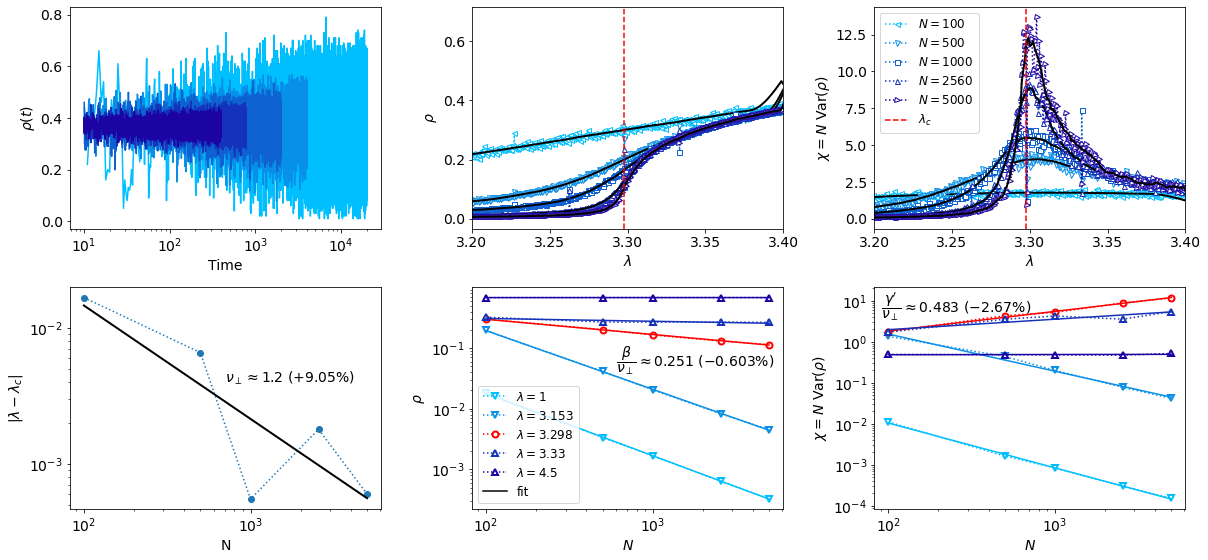

In [ ]:
#colors = plt.get_cmap('cividis')(numpy.linspace(0,1,N_values.size))
import sys
import scipy.signal
import modules.misc_func as misc
if misc:
    del sys.modules['modules.misc_func']
    del misc
import modules.misc_func as misc
import modules.plot_func as pltt
if pltt:
    del sys.modules['modules.plot_func']
    del pltt
import modules.plot_func as pltt
import modules.correlation as corr
import modules.phasetransdata as ptd

data_to_plot        = ['seq']
use_filter_suscept  = False

# critical exponents DP 1-dim
# Munoz et al (1999) PRE 59:6175-6179
l_c_seq               = 3.297848 # critical point
nuperp_theory         = 1.09684
beta_theory           = 0.27649
beta_nuperp_theory    = beta_theory/nuperp_theory
gammapr_nuperp_theory = 0.54386/nuperp_theory
outlier_args          = dict(window=20,z_score_local_threshold=3)
wiener_filter_params  = {
     100:dict(mysize=70,noise=20),
     500:dict(mysize=40,noise=20),
    1000:dict(mysize=30,noise=10),
    2560:dict(mysize=10,noise= 5),
    5000:dict(mysize=10,noise= 5)
}

# fitting rho and susceptibility vs. N
rho_l_N_seq_all     = numpy.array([pt.rho     for pt in pt_seq_TO]).T
suscept_l_N_seq_all = numpy.array([pt.suscept for pt in pt_seq_TO]).T
fr_rho_all          = [ misc.linearized_fit(N_values,Y,x_transform=numpy.log,y_transform=numpy.log,y_inverse_transform=numpy.exp) for Y in rho_l_N_seq_all     ]
fr_sus_all          = [ misc.linearized_fit(N_values,Y,x_transform=numpy.log,y_transform=numpy.log,y_inverse_transform=numpy.exp) for Y in suscept_l_N_seq_all ]

# estimating the critical point by the best fit to the beta/nu_perp exponent
k_min_beta          = numpy.argmin(numpy.abs(numpy.array([-fr.fitpar[0] for fr in fr_rho_all])    - beta_nuperp_theory   ) )
beta_nuperp_fit     = -fr_rho_all[k_min_beta].fitpar[0]
gammapr_nuperp_fit  =  fr_sus_all[k_min_beta].fitpar[0]
l_c_app_seq         = pt_seq_TO[0].l[k_min_beta]
err_per             = lambda vfit,vtheory: 100*(vfit-vtheory)/vtheory


l_rho_smooth,rho_smooth = misc.unpack_list_of_tuples([ misc.smooth_data(pt.rho    , scipy.signal.wiener, wiener_filter_params[N],outlier_args,x=pt.l) for pt,N in zip(pt_seq_TO,N_values) ])
l_sus_smooth,sus_smooth = misc.unpack_list_of_tuples([ misc.smooth_data(pt.suscept, scipy.signal.wiener, wiener_filter_params[N],outlier_args,x=pt.l) for pt,N in zip(pt_seq_TO,N_values) ])
l_sus_max   ,sus_max    = misc.unpack_list_of_tuples([ (lval[(k:=numpy.nanargmax(sus))],sus[k]) for lval,sus in zip(l_sus_smooth,sus_smooth)])
l_sus_max               = numpy.asarray(l_sus_max)
sus_max                 = numpy.asarray(sus_max  )
l_c_max_shift           = numpy.abs(l_sus_max-l_c_app_seq)
fr_sus_max              = misc.linearized_fit(N_values,l_c_max_shift,x_transform=numpy.log,y_transform=numpy.log, y_inverse_transform=numpy.exp)#, mask=numpy.array([1,1,0,1,1],dtype=bool))
nuperp_fit              = -1/fr_sus_max.fitpar[0]

# selecting data for FSS plot
l_probe_seq                       = pt_seq_TO[0].l[numpy.linspace(0,pt_seq_TO[0].l.size-1,5,dtype=int)]
l_probe_seq[2]                    = l_c_app_seq
l_selected_seq,l_selected_ind_seq = misc.find_closest_value(pt_seq_TO[0].l,l_probe_seq, return_all=True)
rho_l_N_seq                       = rho_l_N_seq_all[l_selected_ind_seq]
suscept_l_N_seq                   = suscept_l_N_seq_all[l_selected_ind_seq]
fr_rho                            = [ fr_rho_all[k] for k in l_selected_ind_seq]
fr_sus                            = [ fr_sus_all[k] for k in l_selected_ind_seq]


# generating matrices rho[l,N] suscept[l,N]
print('* known critical point:')
print( f'𝜆_c    = {l_c_seq              :.6g}')
print( f'𝜈⟂    = {nuperp_theory        :.6g}')
print( f'𝛽/𝜈⟂  = {beta_nuperp_theory   :.6g}')
print(f'𝛾\'/𝜈⟂ = {gammapr_nuperp_theory:.6g}')
print('')
print('')
print('* estimated critical point:')
print( f'𝜆_c    = {l_c_app_seq       :.6g} \t ({err_per(l_c_app_seq       ,l_c_seq              ):.4g}%)')
print( f'𝜈⟂    = {nuperp_fit         :.6g} \t ({err_per(nuperp_fit       ,nuperp_theory        ):.4g}%)')
print( f'𝛽/𝜈⟂  = {beta_nuperp_fit   :.6g} \t ({err_per(beta_nuperp_fit   ,beta_nuperp_theory   ):.4g}%)')
print(f'𝛾\'/𝜈⟂ = {gammapr_nuperp_fit:.6g} \t ({err_per(gammapr_nuperp_fit,gammapr_nuperp_theory):.4g}%)')
print('')
print('')

colors_seq     = pltt.cmap_blue_deep()(   numpy.linspace(0,1,N_values.size))
colors_seq_FSS = pltt.cmap_blue_deep()(   numpy.linspace(0,1,l_selected_seq.size))
colors_seq_FSS[2,:] = numpy.array([1,0,0,1])
marker_seq_FSS      = 'vvo^^'
marker_N            = '<vs^>'

plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(17,8))

ax[0,2].sharex(ax[0,1])
#ax[1,0].set_visible(False)

# which lambda to show time series for

ax[1,0].plot(N_values,l_c_max_shift,'o:')
ax[1,0].plot(fr_sus_max.x_fit,fr_sus_max.y_fit,'-k',linewidth=2,label=f'$\\nu_\\perp\\approx{nuperp_fit:.4g}$')
ax[1,0].text(7e2,4e-3,f'$\\nu_\\perp\\approx{nuperp_fit:.3g}\\ ({err_per(nuperp_fit       ,nuperp_theory        ):+.3g}\\%)$')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel('$|\\lambda-\\lambda_c|$')

ind = -1
for k,N in enumerate(N_values):
    if len(d_seq_TO[k]):
        ax[0,0].plot(d_seq_TO[k][ind].time/d_seq_TO[k][ind].N , d_seq_TO[k][ind].rho     ,'-',label=f'$N={N}$',color=colors_seq[k])
    ax[0,1].plot(    pt_seq_TO[k].l                           , pt_seq_TO[k].rho         ,':',label=f'$N={N}$',color=colors_seq[k],marker=marker_N[k],markersize=5,markerfacecolor='w')
    ax[0,1].plot(    l_rho_smooth[k]                          , rho_smooth[k]            ,'-',label=f'_$N={N}$',color='k',linewidth=2)
    ax[0,2].plot(    pt_seq_TO[k].l                           , pt_seq_TO[k].suscept     ,':',label=f'$N={N}$',color=colors_seq[k],marker=marker_N[k],markersize=5,markerfacecolor='w')
    ax[0,2].plot(    l_sus_smooth[k]                          , sus_smooth[k]            ,'-',label=f'_$N={N}$',color='k',linewidth=2)

ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('$\\rho(t)$')
ax[0,0].set_xscale('log')
ax[0,1].set_xlabel('$\\lambda$')
ax[0,1].set_ylabel('$\\rho$')
ax[0,2].set_xlabel('$\\lambda$')
ax[0,2].set_ylabel('$\chi=N$ Var($\\rho$)')

#ax[0,1].set_xlim((0.25,0.35))
#ax[0,1].set_xlim((1.5,4.0))
ax[0,1].set_xlim((3.2,3.4))
#ax[0,2].set_ylim((5e-3,1e1))
#ax[0,2].set_ylim((0,4))
ax[0,1].axvline(l_c_seq,ls='--',color='r',label='$\\lambda_c$')
ax[0,2].axvline(l_c_seq,ls='--',color='r',label='$\\lambda_c$')

for k,l in enumerate(l_selected_seq):
    ax[1,1].plot(N_values    ,rho_l_N_seq[k]      ,':',label= f'$\\lambda={l:.4g}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2,marker=marker_seq_FSS[k])
    ax[1,1].plot(fr_rho[k].x_fit,fr_rho[k].y_fit  ,'-',label=f'_$\\lambda={l:.4g}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)
    ax[1,2].plot(N_values,suscept_l_N_seq[k]      ,':',label= f'$\\lambda={l:.4g}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2,marker=marker_seq_FSS[k])
    ax[1,2].plot(fr_sus[k].x_fit,fr_sus[k].y_fit  ,'-',label=f'_$\\lambda={l:.4g}$',color=colors_seq_FSS[k],markerfacecolor='w',markeredgewidth=2)

ax[1,1].text(6e2,5e-2,f'$\\dfrac{{\\beta}}{{\\nu_\\perp}}\\approx{beta_nuperp_fit:.3g}\\ ({err_per(beta_nuperp_fit   ,beta_nuperp_theory   ):+.3g}\\%)$')
ax[1,2].text(9e1,5e0 ,f'$\\dfrac{{\\gamma^\\prime}}{{\\nu_\\perp}}\\approx{gammapr_nuperp_fit:.3g}\\ ({err_per(gammapr_nuperp_fit,gammapr_nuperp_theory):+.3g}\\%)$')
ax[1,1].plot(numpy.nan,numpy.nan,'-k',label='fit')
ax[1,1].set_xlabel('$N$')
ax[1,1].set_ylabel('$\\rho$')
ax[1,2].set_xlabel('$N$')
ax[1,2].set_ylabel('$\chi=N$ Var($\\rho$)')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')

plt.tight_layout()
ax[0,2].legend(bbox_to_anchor=( 0.0,1.0), loc='upper left' , fontsize=12)
ax[1,1].legend(bbox_to_anchor=( 0.0,0.0), loc='lower left', fontsize=12)
#ax[1,1].legend(bbox_to_anchor=(-0.25,1.0), loc='upper right', fontsize=12)


plt.show()


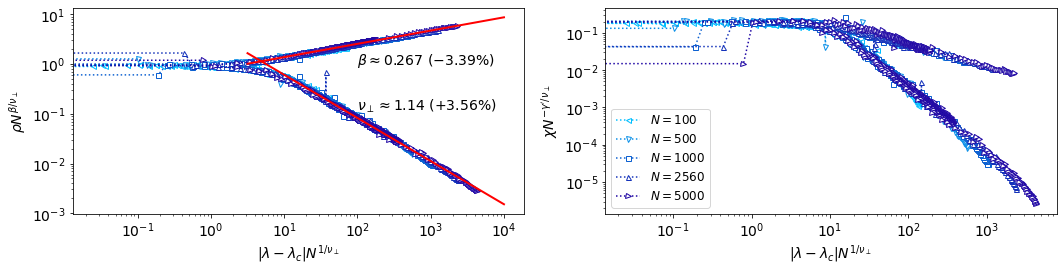

In [ ]:


nuperp_collapse     = 1.13

rho_scaling_func    = [ pt.rho * N**(beta_nuperp_fit)  for pt,N in zip(pt_seq_TO,N_values) ]
l_shift_rho_scaling = [ numpy.abs(pt.l - l_c_app_seq) * N**(1/nuperp_collapse)  for pt,N in zip(pt_seq_TO,N_values) ]
var_scaling_func    = [ pt.suscept * N**(-gammapr_nuperp_fit)  for pt,N in zip(pt_seq_TO,N_values) ]
l_shift_var_scaling = [ numpy.abs(pt.l - l_c_app_seq) * N**(1/nuperp_collapse)  for pt,N in zip(pt_seq_TO,N_values) ]

fr_rho_scaling_tail_up  = misc.linearized_fit(ls:=numpy.hstack(l_shift_rho_scaling), rhos:=numpy.hstack(rho_scaling_func), numpy.log, numpy.log, numpy.exp, (ls>15.0) & (rhos > 1))
fr_rho_scaling_tail_low = misc.linearized_fit(ls:=numpy.hstack(l_shift_rho_scaling), rhos:=numpy.hstack(rho_scaling_func), numpy.log, numpy.log, numpy.exp, (ls>15.0) & (rhos < 1))
l_shift_fit_values      = numpy.logspace(0.5,4,5)

beta_fit        = fr_rho_scaling_tail_up.fitpar[0]
nuperp_fit_scal = beta_fit - fr_rho_scaling_tail_low.fitpar[0]


plt.rcParams.update({'font.size':14})
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

for k,N in enumerate(N_values):
    ax[0].plot( l_shift_rho_scaling[k] , rho_scaling_func[k] ,':',label=f'$N={N}$',color=colors_seq[k],marker=marker_N[k],markersize=5,markerfacecolor='w')
    ax[1].plot( l_shift_var_scaling[k] , var_scaling_func[k] ,':',label=f'$N={N}$',color=colors_seq[k],marker=marker_N[k],markersize=5,markerfacecolor='w')
ax[0].plot(l_shift_fit_values, fr_rho_scaling_tail_up.func(l_shift_fit_values, *fr_rho_scaling_tail_up.fitpar),'-r', linewidth=2)
ax[0].plot(l_shift_fit_values,fr_rho_scaling_tail_low.func(l_shift_fit_values,*fr_rho_scaling_tail_low.fitpar),'-r', linewidth=2)

ax[0].text(1e2,1e0 ,f'$\\beta\\approx{beta_fit:.3g}\\ ({err_per(beta_fit   ,beta_theory   ):+.3g}\\%)$')
ax[0].text(1e2,1.2e-1 ,f'$\\nu_\\perp\\approx{nuperp_fit_scal:.3g}\\ ({err_per(nuperp_fit_scal,nuperp_theory):+.3g}\\%)$')
ax[0].set_xlabel('$|\\lambda-\\lambda_c|N^{1/\\nu_\\perp}$')
ax[0].set_ylabel('$\\rho N^{\\beta/\\nu_\\perp}$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xlabel('$|\\lambda-\\lambda_c|N^{1/\\nu_\\perp}$')
ax[1].set_ylabel('$\\chi N^{-\\gamma^\\prime/\\nu_\\perp}$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

plt.tight_layout()
ax[1].legend(bbox_to_anchor=( 0.0,0.0), loc='lower left' , fontsize=12)


plt.show()


## interactive plot

In [ ]:
import plotly.graph_objects as go
import scipy.signal
import numpy

def local_outlier_filter(y, window=20, threshold=3):
    y = numpy.asarray(y)
    filtered = numpy.ones_like(y, dtype=bool)
    for i in range(len(y)):
        start = max(0, i - window // 2)
        end = min(len(y), i + window // 2)
        local = y[start:end]
        local_mean = numpy.mean(local)
        local_std = numpy.std(local)
        if abs(y[i] - local_mean) > threshold * local_std:
            filtered[i] = False
    return filtered

wiener_params = {
     100:[70,20],
     500:[40,20],
    1000:[30,10],
    2560:[15, 5],
    5000:[15, 5]
}

ind = -5

# Assuming pt_seq_TO[-1].l and pt_seq_TO[-1].suscept are NumPy arrays
x           = pt_seq_TO[ind].l
y_raw       = pt_seq_TO[ind].suscept
no_out_mask = local_outlier_filter(y_raw, 20, 3)
x_noout     = x[no_out_mask]
y_noout     = y_raw[no_out_mask]
y_ma        = corr.moving_average(y_noout, 20)
y_wiener    = scipy.signal.wiener(y_noout, 70, 20)

fig = go.Figure()

#fig.add_trace(go.Scatter(   x=x,    y=y_raw,    mode='markers',    name='Raw susceptibility',    marker=dict(symbol='circle', size=6, color='blue')))
fig.add_trace(go.Scatter(   x=x_noout,    y=y_noout,    mode='markers',    name='Raw susceptibility',    marker=dict(symbol='circle', size=6, color='green')))
fig.add_trace(go.Scatter(    x=x,    y=y_ma,    mode='lines',    name='Moving average',    line=dict(color='black', dash='solid')))
fig.add_trace(go.Scatter(    x=x,    y=y_wiener,    mode='lines',    name='Wiener filter',    line=dict(color='red', dash='solid')))
fig.update_layout(    title='Susceptibility Smoothing Comparison',    xaxis_title='λ',    yaxis_title='χ',    legend_title='Method',    height=500,    width=800)
fig.update_xaxes(range=[3.2, 3.4])
fig.show()